# GRT Plotting Tests

In this notebook we will develop and test the graphical capabilities of GRT

In [8]:
from gravray import *
from gravray.util import *
from gravray.sampling import *
from gravray.spice import *
from gravray.orbit import *
from gravray.stats import *
from gravray.plot import *

import pandas as pd
from IPython.display import Image

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%matplotlib nbagg

In [5]:
%matplotlib nbagg

In [6]:
Util.log=np.log

## Type of graphics

There are several types of graphics:

1. Maps (projection on sky)

2. Plot of points or distribution in N-d, in multiple 2-d subplots 

3. Scatter and surface plots in 3d

### Plost of points in 2-d subplots

In [86]:
#We have a distribution of points in N-d
weights=[0.6]
locs=[
    [0.5,0.5,-2.0],
    [2.0,0.3,-2.6]
]
scales=[
    [1.3,0.7,0.5],
    [0.4,0.9,1.6]
]
angles=[
    [-40.0*Angle.Deg,-86.0*Angle.Deg,0.0*Angle.Deg],
    [+80.0*Angle.Deg,-109.0*Angle.Deg,0.0*Angle.Deg]
]
ranges=[
    [0.0,1.0],
    [0.0,1.0]
]
mnd=MultiVariate([1,1,1,0,0])
mnd.setUnflatten(weights,locs,scales,angles,ranges)
ps=mnd.rvs(1000)

In [87]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [237]:
class PlotGrid(object):
    """
    Class PlotGrid
    
    Create a grid of plots showing the projection of a N-dimensional
    
    Initialization attributes:
        dproperties: list of properties to be shown, dictionary of dictionaries (N entries)
            keys: label of attribute, ex. "q"
            dictionary: 
                label: label used in axis, string
                range: range for property, tuple (2)
        
    Optional initialization attributes:
        figsize=3 : base size for panels (the size of figure will be M x figsize), integer
        fontsize=10 : base fontsize, int
        direction='out' : direction of ticks in panels.
    
    Other attributes:
        N: number of properties, int
        M: size of grid matrix (M=N-1), int
        fw: figsize
        fs: fontsize
        fig: figure handle, figure
        axs: matrix with subplots, axes handles (MxM)
        axp: matrix with subplots, dictionary of dictionaries
        properties: list of properties labels, list of strings (N)
    
    Methods:
        tightLayout
        setLabels
        setRanges
        setTickParams
        
        plotHist
        scatterPlot
    """
    
    def __init__(self,properties,figsize=3,fontsize=10,direction='out'):

        #Basic attributes
        self.dproperties=properties
        self.properties=list(properties.keys())

        #Secondary attributes
        self.N=len(properties)
        self.M=self.N-1
        
        #Optional properties
        self.fw=figsize
        self.fs=fontsize

        #Create figure and axes: it works
        try:
            self.fig,self.axs=plt.subplots(
                self.M,self.M,
                constrained_layout=True,
                figsize=(self.M*self.fw,self.M*self.fw),
                sharex="col",sharey="row"
            )
            self.constrained=True
        except:
            self.fig,self.axs=plt.subplots(
                self.M,self.M,
                figsize=(self.M*self.fw,self.M*self.fw),
                sharex="col",sharey="row"
            )
            self.constrained=False
            
        #Create named axis
        self.axp=dict()
        for j in range(self.N):
            propj=self.properties[j]
            if propj not in self.axp.keys():
                self.axp[propj]=dict()
            for i in range(self.N):
                propi=self.properties[i]
                if i==j:
                    continue
                if propi not in self.axp.keys():
                    self.axp[propi]=dict()
                if i<j:
                    self.axp[propj][propi]=self.axp[propi][propj]
                    continue
                self.axp[propj][propi]=self.axs[i-1][j]
    
        #Deactivate unused panels
        for i in range(self.M):
            for j in range(i+1,self.M):
                self.axs[i][j].axis("off")
        
        #Place ticks
        for i in range(self.M):
            for j in range(i+1):
                self.axs[i,j].tick_params(axis='both',direction=direction)
        for i in range(self.M):
            self.axs[i,0].tick_params(axis='y',direction="out")
            self.axs[self.M-1,i].tick_params(axis='x',direction="out")
        
        #Set properties of panels
        self.setLabels()
        self.setRanges()
        self.setTickParams()
        self.tightLayout()
    
    def tightLayout(self):
        """
        Tight layout if no constrained_layout was used.
        
        Parameters: None
        
        Return: None
        """
        if self.constrained==False:
            self.fig.tight_layout()
            self.fig.subplots_adjust(wspace=self.fw/100.,hspace=self.fw/100.)
        
    def setTickParams(self,**args):
        """
        Set tick parameters.
        
        Parameters: 
            **args: same arguments as tick_params method, dictionary
        
        Return: None
        """
        opts=dict(axis='both',which='major',labelsize=0.8*self.fs)
        opts.update(args)
        for i in range(self.M):
            for j in range(self.M):
                self.axs[i][j].tick_params(**opts)
        
    def setRanges(self):
        """
        Set ranges in panels according to ranges defined in dparameters.
        
        Parameters: None
        
        Return: None
        """
        for i,propi in enumerate(self.properties):
            for j,propj in enumerate(self.properties):
                if j<=i:continue
                if self.dproperties[propi]["range"] is not None:
                    self.axp[propi][propj].set_xlim(self.dproperties[propi]["range"])
                if self.dproperties[propj]["range"] is not None:
                    self.axp[propi][propj].set_ylim(self.dproperties[propj]["range"])
    
    def setLabels(self,**args):
        """
        Set labels parameters.
        
        Parameters: 
            **args: common arguments of set_xlabel, set_ylabel and text, dictionary
        
        Return: None
        """
        opts=dict(fontsize=self.fs)
        opts.update(args)
        for i,prop in enumerate(self.properties[:-1]):
            label=self.dproperties[prop]["label"]
            self.axs[self.M-1][i].set_xlabel(label,**opts)
        for i,prop in enumerate(self.properties[1:]):
            label=self.dproperties[prop]["label"]
            self.axs[i][0].set_ylabel(label,**opts)
        for i in range(1,self.M):
            label=self.dproperties[self.properties[i]]["label"]
            self.axs[i-1][i].text(0.5,0.0,label,ha='center',
                                  transform=self.axs[i-1][i].transAxes,**opts)
            self.axs[i-1][i].text(0.0,0.5,label,rotation=270,va='center',
                                  transform=self.axs[i-1][i].transAxes,**opts)

        label=self.dproperties[self.properties[0]]["label"]
        self.axs[0][1].text(0.0,1.0,label,rotation=0,ha='left',va='top',
                              transform=self.axs[0][1].transAxes,**opts)

        label=self.dproperties[self.properties[-1]]["label"]
        self.axs[-1][-1].text(1.05,0.5,label,rotation=270,ha='left',va='center',
                              transform=self.axs[-1][-1].transAxes,**opts)

        self.tightLayout()
        
    def plotHist(self,data,colorbar=False,**args):
        """
        Create a 2d-histograms of data on all panels of the PlotGrid.
        
        Parameters: 
            data: data to be histogramed (n=len(data)), numpy array (nxN)
            
        Optional parameters:
            colorbar=False: include a colorbar?, boolean or int (0/1)
            **args: all arguments of hist2d method, dictionary
        
        Return: 
            hist: list of histogram instances.
        """
        opts=dict()
        opts.update(args)

        hist=[]
        for i,propi in enumerate(self.properties):
            for j,propj in enumerate(self.properties):
                if j<=i:continue
                h,xe,ye,im=self.axp[propi][propj].hist2d(data[:,i],data[:,j],**opts)
                hist+=[im]
                if colorbar:
                    #Create color bar
                    divider=make_axes_locatable(self.axp[propi][propj])
                    cax=divider.append_axes("top",size="7%",pad=0.1)
                    self.fig.add_axes(cax)
                    cticks=np.linspace(h.min(),h.max(),10)[2:-1]
                    self.fig.colorbar(im,
                                      ax=self.axp[propi][propj],
                                      cax=cax,
                                      orientation="horizontal",
                                      ticks=cticks)
                    cax.xaxis.set_tick_params(labelsize=0.5*self.fs,direction="in",pad=-0.8*self.fs)
                    xt=cax.get_xticks()
                    xm=xt.mean()
                    m,e=Util.mantisaExp(xm)
                    xtl=[]
                    for x in xt:
                        xtl+=["%.1f"%(x/10**e)]
                    cax.set_xticklabels(xtl)
                    cax.text(0,0.5,r"$\times 10^{%d}$"%e,ha="left",va="center",
                             transform=cax.transAxes,fontsize=6,color='w')

        self.setLabels()
        self.setRanges()
        self.setTickParams()
        self.tightLayout()
        return hist
                    
    def scatterPlot(self,data,**args):
        """
        Scatter plot on all panels of the PlotGrid.
        
        Parameters: 
            data: data to be histogramed (n=len(data)), numpy array (nxN)
            
        Optional parameters:
            **args: all arguments of scatter method, dictionary
        
        Return: 
            scatter: list of scatter instances.
        """
        scatter=[]
        for i,propi in enumerate(self.properties):
            for j,propj in enumerate(self.properties):
                if j<=i:continue
                scatter+=[self.axp[propi][propj].scatter(data[:,i],data[:,j],**args)]

        self.setLabels()
        self.setRanges()
        self.setTickParams()
        self.tightLayout()
        return scatter

In [238]:
data=np.loadtxt("data/NEOs.txt")
neos=pd.DataFrame(data,columns=["q","e","i","sini","a","Omega","omega"])

neos["Q"]=Util.fin2Inf(neos["q"],1.0)
neos["E"]=Util.fin2Inf(neos["e"],1.0)
neos["I"]=Util.fin2Inf(neos["i"],180.0)
neos["O"]=Util.fin2Uno(neos["Omega"],360.0)
neos["W"]=Util.fin2Uno(neos["omega"],360.0)

sneos=neos[["q","e","i","Omega","omega"]].values
Sneos=neos[["Q","E","I","O","W"]].values

<IPython.core.display.Javascript object>


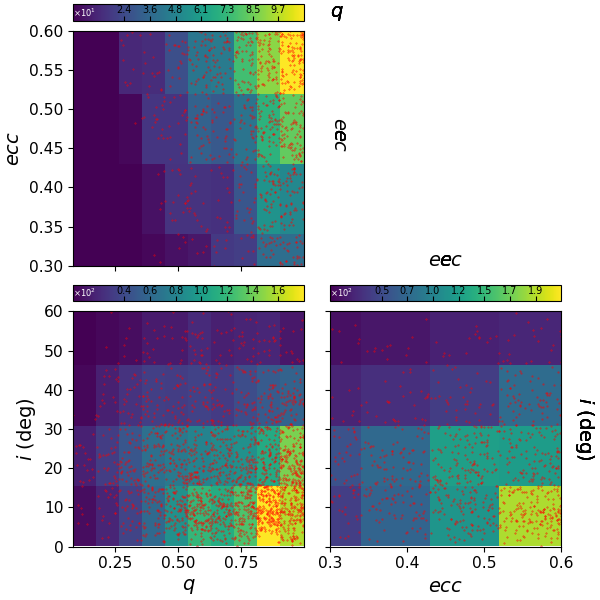

In [239]:
properties=dict(
    q=dict(label=r"$q$",range=None),
    e=dict(label=r"$e$",range=(0.3,0.6)),
    i=dict(label=r"$i$ (deg)",range=(0,60)),
)
G=PlotGrid(properties,figsize=3,fontsize=14)
H=G.plotHist(sneos,colorbar=1)
args=dict(c='r',s=0.1,alpha=1)
S=G.scatterPlot(sneos,**args)

In [236]:
G.setTickLabelParams()#labelsize=12)

In [240]:
ax=G.fig.axes[0]

In [241]:
import matplotlib

In [242]:
for ch in ax.get_children():
    if isinstance(ch,matplotlib.text.Text):
        t=ch

In [243]:
t.set_fontsize(50)

In [244]:
G.dproperties['e']['label']='$ecc$'
G.setLabels()

In [245]:
G.dproperties['e']['range']=(0.3,0.6)

In [246]:
G.setRanges()

<IPython.core.display.Javascript object>


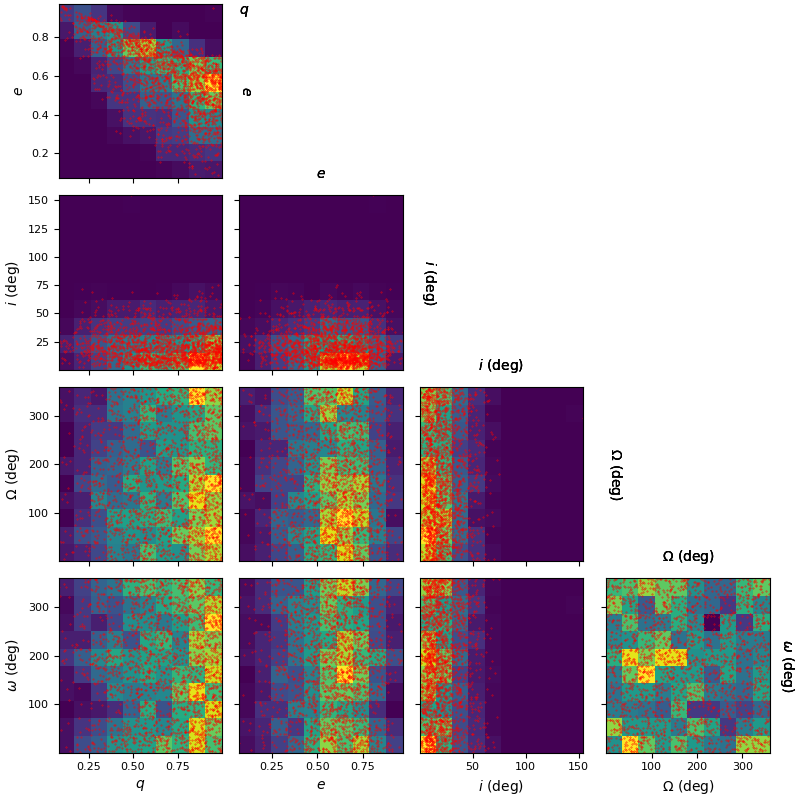

In [247]:
properties=dict(
    q=dict(label=r"$q$",range=None),
    e=dict(label=r"$e$",range=None),
    i=dict(label=r"$i$ (deg)",range=None),
    W=dict(label=r"$\Omega$ (deg)",range=None),
    w=dict(label=r"$\omega$ (deg)",range=None),
)
G3=PlotGrid(properties,figsize=2)

hist=G3.plotHist(sneos)
args=dict(c='r',s=0.1,alpha=1)
scatter=G3.scatterPlot(sneos,**args)

<IPython.core.display.Javascript object>


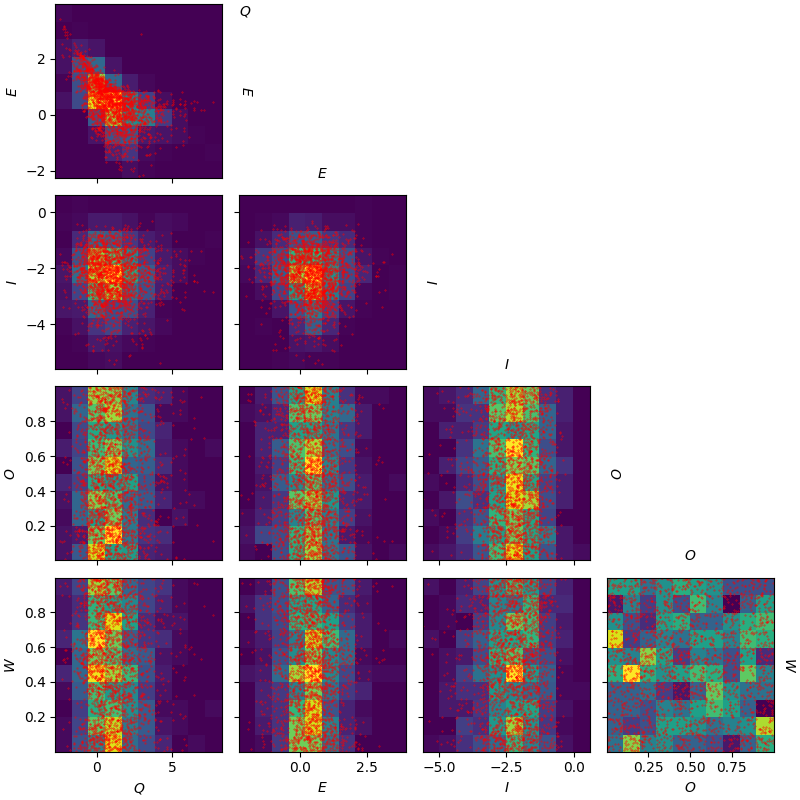

In [185]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$E$",range=None),
    I=dict(label=r"$I$",range=None),
    O=dict(label=r"$O$",range=None),
    W=dict(label=r"$W$",range=None),
)
G=PlotGrid(properties,figsize=2)
#G.plotHist(Sneos)
G.plotHist(ps)
args=dict(c='r',s=0.1,alpha=1)
G.scatterPlot(Sneos,**args)

<IPython.core.display.Javascript object>


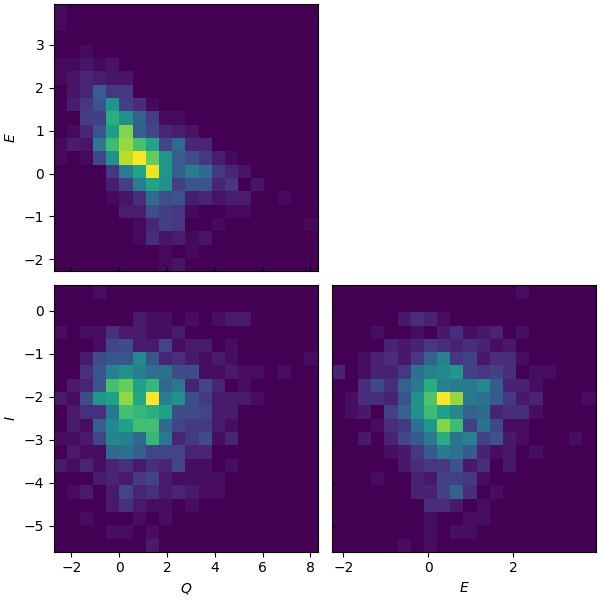

In [97]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$E$",range=None),
    I=dict(label=r"$I$",range=None),
)
G3=PlotGrid(properties,figsize=3)
G3.plotHist(ps,colorbar=0,bins=20,density=0)

In [ ]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$E$",range=None),
    I=dict(label=r"$I$",range=None),
    O=dict(label=r"$O$",range=None),
    W=dict(label=r"$W$",range=None),
)

G=PlotGrid(properties,figsize=2)

In [ ]:
G.plotHist(ps,colorbar=True,bins=30)
G.tightLayout()

In [23]:
data=np.loadtxt("data/NEOs.txt")
neos=pd.DataFrame(data,columns=["q","e","i","sini","a","Omega","omega"])

In [24]:
data=np.loadtxt("data/NEOs.txt")
neos=pd.DataFrame(data,columns=["q","e","i","sini","a","Omega","omega"])

neos["Q"]=Util.fin2Inf(neos["q"],1.0)
neos["E"]=Util.fin2Inf(neos["e"],1.0)
neos["I"]=Util.fin2Inf(neos["i"],180.0)
neos["O"]=Util.fin2Uno(neos["Omega"],360.0)
neos["W"]=Util.fin2Uno(neos["omega"],360.0)

# Map

In [6]:
#Install Basemap using:
#In MacOS: brew install geos
#In Ubuntu: 
#sudo apt-get install libgeos-3.X.X
#sudo apt-get install libgeos-dev
#pip install --user https://github.com/matplotlib/basemap/archive/master.zip
#pip install git+https://github.com/matplotlib/basemap.git
#pip install basemap
from mpl_toolkits.basemap import Basemap as Map,shiftgrid as Grid

In [7]:
s=Sample(100)
s.genUnitSphere()
h=Sample(100)
h.genUnitHemisphere()

In [7]:
s.pp[:,2].min()

-1.4292568534704695

In [11]:
#cl=m.drawcoastlines()
#co=m.drawcountries()
#cf=m.fillcontinents(color='coral',lake_color=None)
cm=m.drawlsmask(land_color='coral',ocean_color='aqua',lakes=True)
CS=m.nightshade(date)

In [152]:
#m.warpimage("figures/moon-map.jpg")
#m.warpimage("figures/moon-map-2.jpg",alpha=0.5)
#m.warpimage("figures/moon-labels.jpg",alpha=0.5)
#Taking from: https://solarsystem.nasa.gov/resources/13048/cassinis-best-maps-of-jupiter-cylindrical-map/
m.warpimage("figures/jupiter-map.jpg",alpha=1)
#m.warpimage("figures/jupiter-map-2.jpg",alpha=1)
#m.warpimage("figures/jupiter-map-3.jpg",alpha=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


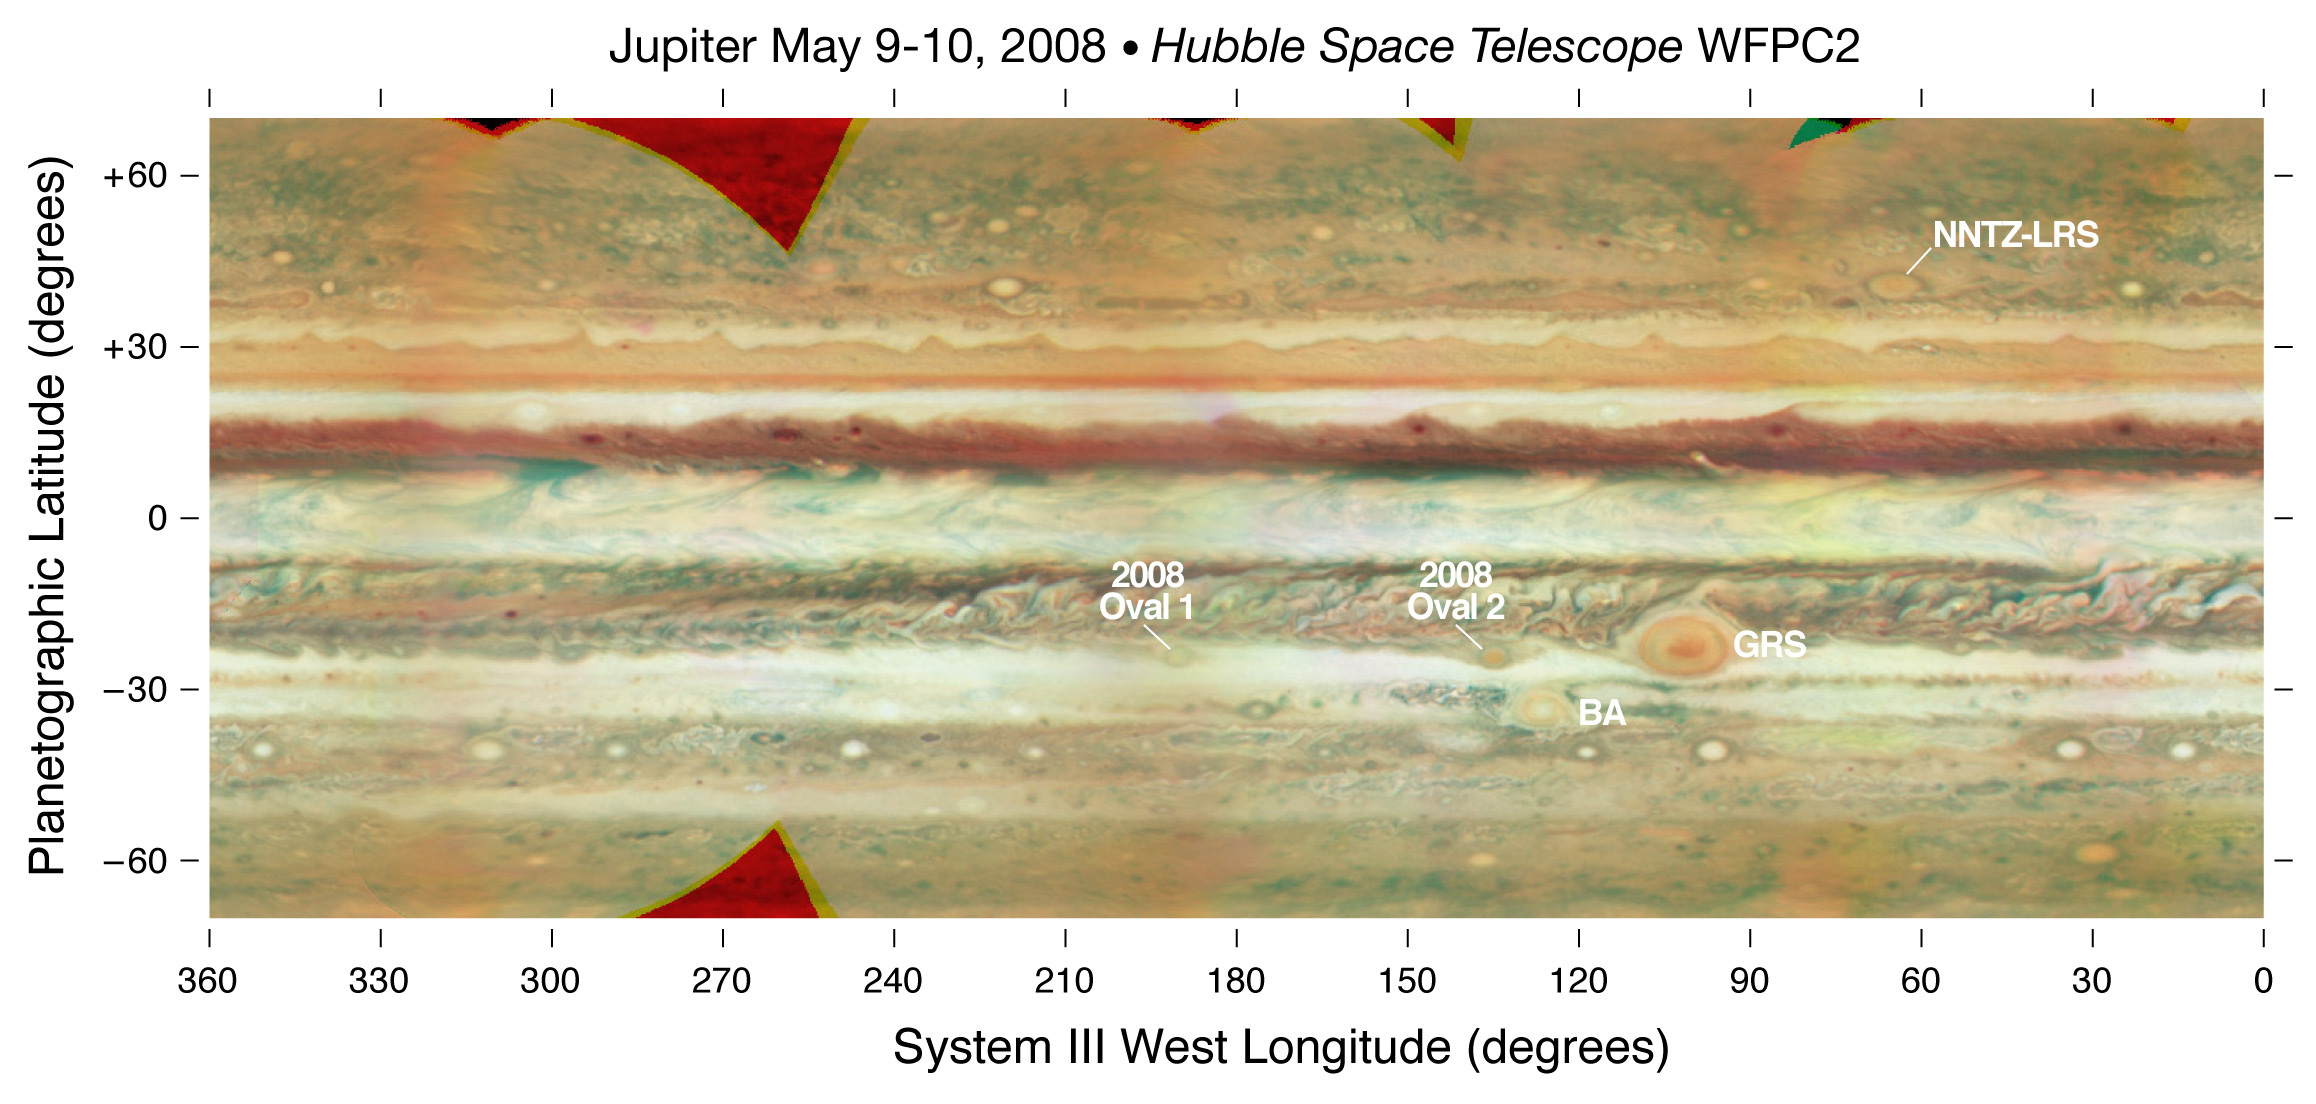

In [147]:
Image(filename='figures/jupiter-systemIII.jpg')

In [133]:
m.drawgreatcircle(-75,10,54,61)

In [125]:
m.bluemarble(alpha=0.3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [56]:
x,y=m(-75.0,6.2)
ax.plot(x,y,'r+')

In [35]:
Pm.shape

(100, 80)

In [50]:
#Lat and lon mesh grid
nlons=100
nlats=120

lons=np.linspace(0,360,nlons)
lats=np.linspace(-90,90,nlats)

P=np.zeros((nlons,nlats))
for i,lon in enumerate(lons):
    for j,lat in enumerate(lats):
        if (lat>-30 and lat<60) and (lon>30 and lon<100):
            P[i,j]=1.0

LONS,LATS=np.meshgrid(lons,lats)
c=m.contourf(LONS,LATS,P.transpose(),latlon=True)

<IPython.core.display.Javascript object>


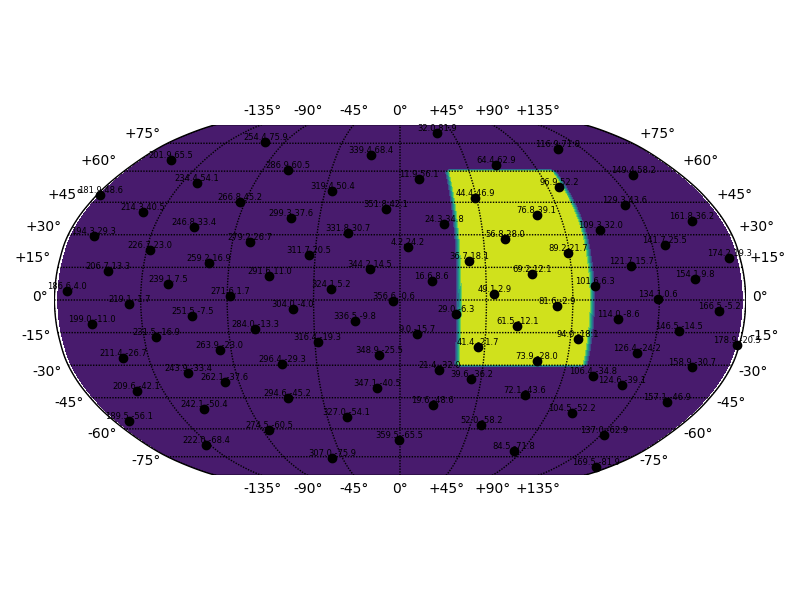

In [49]:
fig=plt.figure(figsize=(8,6))
ax=fig.gca()

#m=Map(projection='eck4',
#m=Map(projection='moll',
m=Map(projection='robin',
      resolution='c',
      lon_0=0)
#
lons=s.pp[:,1]*Angle.Rad
lats=s.pp[:,2]*Angle.Rad
xs,ys=m(lons,lats)
ax.plot(xs,ys,'ko')
for i in range(len(xs)):
    x=xs[i]
    y=ys[i]
    ax.text(x,y,f"{lons[i]:.1f},{lats[i]:.1f}",fontsize=6,ha='center',va='bottom')

#m.drawmapboundary(color='k',fill_color='aqua')
parallels=np.arange(-75,90,15)
parallels=[-75,-60,-45,-30,-15,0,15,30,45,60,75]
m.drawparallels(parallels,labels=[1,1,0,0],labelstyle="+/-")
meridians=np.arange(0,360,45)
#meridians=[0,45,90,135,180,225,270,315]
m.drawmeridians(meridians,labels=[1,1,1,1],labelstyle="+/-")

#cax=plt.axes([0.05,0.1,0.9,0.05])

fig.tight_layout()

In [82]:
hs.min()

-81.89038554400582

In [199]:
nlons=nlats=1000
lons=np.linspace(0,360,nlons)
lats=np.linspace(-90,90,nlats)
LONS,LATS=np.meshgrid(lons,lats)
P=np.zeros_like(LONS)
cond=LATS>0
P[cond]=1
Pm,glons=Grid(180.0,P,lons,start=False)
LONS,LATS=np.meshgrid(glons,lats)
LN,LT=m(LONS,LATS)
m.contour(LN,LT,Pm,levels=[0,1],colors=['k'],lw=2)
m.contourf(LN,LT,Pm,vmin=0,vmax=1,cmap="flag_r")
#m.contourf(LN,LT,Pm,vmin=0,vmax=1,cmap="colorcube")

In [81]:
#Lat and lon mesh grid
nlons=300
nlats=300

lons=np.linspace(0,360,nlons)
lats=np.linspace(-90,90,nlats)

P=np.zeros((nlons,nlats))
for i,lon in enumerate(lons):
    for j,lat in enumerate(lats):
        if (lat>10 and lat<45) and (lon>145 and lon<260):
            P[i,j]=1.0

LONS,LATS=np.meshgrid(lons,lats)
#c=m.contourf(LONS,LATS,P.transpose(),latlon=True)
c=m.contourf(LONS,LATS,P.transpose(),cmap='flag_r',latlon=True)
#c=m.contour(LONS,LATS,P.transpose(),levels=[1],colors='k',latlon=True)

<IPython.core.display.Javascript object>


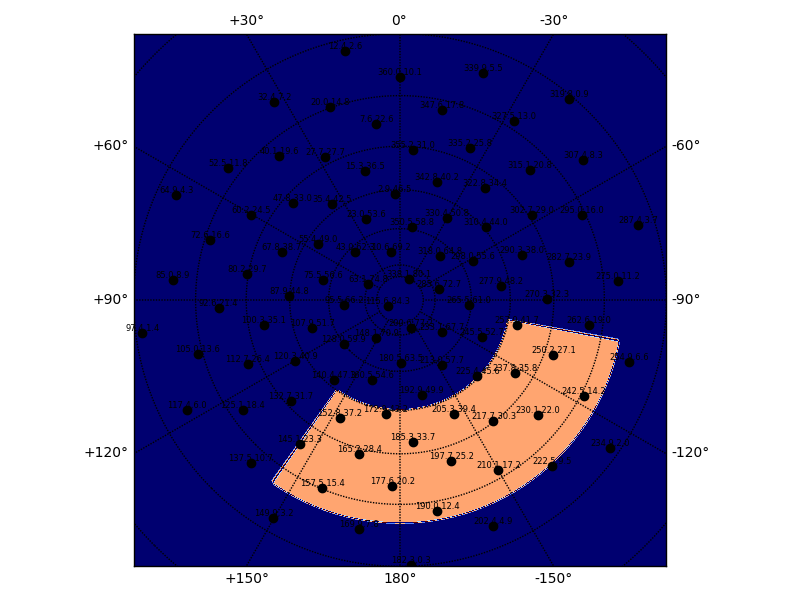

In [80]:
fig=plt.figure(figsize=(8,6))
ax=fig.gca()

m=Map(projection='npstere',
#m=Map(projection='npaeqd',
      boundinglat=0,
      resolution='l',
      lon_0=180)
#
As=h.pp[:,1]*Angle.Rad
hs=h.pp[:,2]*Angle.Rad
xs,ys=m(As,hs)
ax.plot(xs,ys,'ko')
for i in range(len(xs)):
    x=xs[i]
    y=ys[i]
    ax.text(x,y,f"{As[i]:.1f},{hs[i]:.1f}",fontsize=6,ha='center',va='bottom')

m.drawmapboundary(color='k',fill_color='w')
parallels=np.arange(-75,90,15)
parallels=[-75,-60,-45,-30,-15,0,15,30,45,60,75]
m.drawparallels(parallels,labels=[0,0,0,0],labelstyle="+/-")
meridians=np.arange(0,360,30)
#meridians=[0,45,90,135,180,225,270,315]
m.drawmeridians(meridians,labels=[1,1,1,1],labelstyle="+/-")

#cax=plt.axes([0.05,0.1,0.9,0.05])

fig.tight_layout()

In [79]:
#Lat and lon mesh grid
nlons=100
nlats=120

lons=np.linspace(0,360,nlons)
lats=np.linspace(-90,90,nlats)

P=np.zeros((nlons,nlats))
for i,lon in enumerate(lons):
    for j,lat in enumerate(lats):
        if (lat>0 and lat<30) and (lon>145 and lon<260):
            P[i,j]=1.0

LONS,LATS=np.meshgrid(lons,lats)
c=m.contourf(LONS,LATS,P.transpose(),latlon=True)

<IPython.core.display.Javascript object>


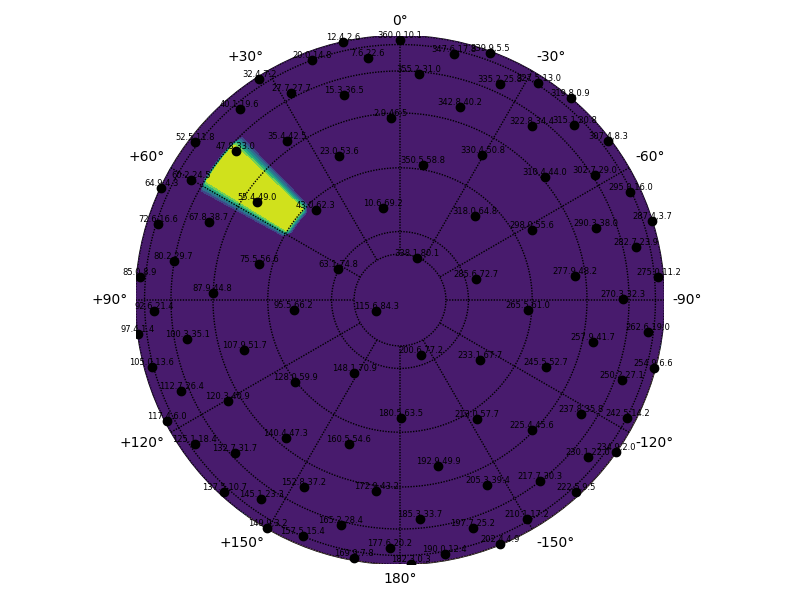

In [57]:
fig=plt.figure(figsize=(8,6))
ax=fig.gca()

m=Map(projection='ortho',
      lat_0=90,
      resolution='c',
      lon_0=180)
#
As=h.pp[:,1]*Angle.Rad
hs=h.pp[:,2]*Angle.Rad
xs,ys=m(As,hs)
ax.plot(xs,ys,'ko')
for i in range(len(xs)):
    x=xs[i]
    y=ys[i]
    ax.text(x,y,f"{As[i]:.1f},{hs[i]:.1f}",fontsize=6,ha='center',va='bottom')

m.drawmapboundary(color='k') #,fill_color='c')
parallels=np.arange(-75,90,15)
parallels=[-75,-60,-45,-30,-15,0,15,30,45,60,75]
m.drawparallels(parallels,labels=[1,1,0,0],labelstyle="+/-")
meridians=np.arange(0,360,30)
#meridians=[0,45,90,135,180,225,270,315]
m.drawmeridians(meridians,labels=[1,1,1,1],labelstyle="+/-")

#cax=plt.axes([0.05,0.1,0.9,0.05])

fig.tight_layout()

In [511]:
from mpl_toolkits.basemap import Basemap,shiftgrid
from datetime import datetime

class Map(object):
    
    #warpimage
    #Valid: image="earth-map.jpg"
    image=None
    warpimage=dict(alpha=1)
    
    #lsmask
    drawlsmask=dict(land_color='coral',ocean_color='aqua',lakes=True)

    #Decoration atributtes
    drawmapboundary=dict(color='k',fill_color='aqua')

    #Parallels
    parallels=np.arange(-75,90,15)
    drawparallels=dict(labels=[1,1,0,0],labelstyle="+/-")

    almucantars=np.arange(0.0,90.0,15)
    drawalmucantars=dict(labels=[0,0,0,0],labelstyle="+/-",color='w')

    #Meridians
    meridians=np.arange(0,360,45.0)
    drawmeridians=dict(labels=[1,1,1,1],labelstyle="+/-",color='k')

    verticals=np.arange(0,360,30.0)
    drawverticals=dict(labels=[1,1,1,1],labelstyle="+/-",color='w')
    
    self.horizon=['g','k']
    

    #Coastlines
    drawcoastlines=dict(linewidth=1,linestyle="solid",color='k')
    
    #Continents
    drawcontinents=dict(linewidth=1,linestyle="solid",color='k')

    #Countries
    drawcountries=dict(linewidth=1,linestyle="solid",color='k')

    #Fill continents
    fillcontinents=dict(color='coral',lake_color=None)

    #Nightshade
    date=datetime.utcnow()
    nightshade=dict(color='k',delta=0.25,alpha=0.5)
    
    def __init__(self,maptype,ax,**args):

        self.maptype=maptype
        self.ax=ax

        #Select type of map
        if maptype=="sky":
            #Other: projection='npaeqd'
            opts=dict(projection='npstere',boundinglat=0,resolution='l',lon_0=180)
            opts.update(args)
        elif maptype=="surface":
            opts=dict(projection='robin',resolution='c',lon_0=0)
            opts.update(args)            
        else:
            raise ValueError(f"Map type {maptype} not recognized")

        self.area=Basemap(**opts)
        self.mapopts=deepcopy(opts)
    
    def setDecoration(self):

        #Draw boundary
        if self.drawmapboundary is not None:
            self.area.drawmapboundary(ax=self.ax,**self.drawmapboundary)

        if self.maptype=="surface":
            #Draw meridians and parallels
            if self.drawparallels is not None:
                self.area.drawparallels(self.parallels,ax=self.ax,**self.drawparallels)
            if self.drawmeridians is not None:
                self.area.drawmeridians(self.meridians,ax=self.ax,**self.drawmeridians)

            #Background
            if self.image is not None:
                self.area.warpimage(ROOTDIR+"/data/"+self.image,**self.warpimage)
            elif self.drawlsmask is not None:
                self.area.drawlsmask(**self.drawlsmask)
            else:
                #Draw coastlines
                if self.drawcoastlines is not None:
                    self.area.drawcoastlines(ax=self.ax,**self.drawcoastlines)
                if self.drawcountries is not None:
                    self.area.drawcountries(ax=self.ax,**self.drawcountries)
                if self.fillcontinents is not None:
                    self.area.fillcontinents(ax=self.ax,**self.fillcontinents)
                #Night shade
                if self.nightshade is not None:
                    self.area.nightshade(self.date,ax=self.ax,**self.nightshade)
                    
        elif self.maptype=="sky":
            if self.drawalmucantars is not None:
                self.area.drawparallels(self.almucantars,ax=self.ax,**self.drawalmucantars)
            if self.drawverticals is not None:
                self.area.drawmeridians(self.verticals,ax=self.ax,**self.drawverticals)
            
            #Separate floor from sky
            fun=lambda lon,lat:1 if lat>0 else 0
            lons=np.linspace(0,360.0,100)
            lats=np.linspace(-30,90.0,100)
            cmap=colors.ListedColormap(['g','k'])
            self.contourFunction(fun,lons,lats,levels=[0,1],colors=['k'],lw=2)
            self.contourfFunction(fun,lons,lats,vmin=0,vmax=1,cmap=cmap)
                
    def contourFunction(self,function,lons,lats,**args):
        #Lat and lon mesh grid
        P=np.zeros((len(lons),len(lats)))
        for i,lon in enumerate(lons):
            for j,lat in enumerate(lats):
                P[i,j]=function(lon,lat)
        LONS,LATS=np.meshgrid(lons,lats)
        c=self.area.contour(LONS,LATS,P.transpose(),latlon=True,**args)
        return c

    def contourfFunction(self,function,lons,lats,**args):
        #Lat and lon mesh grid
        P=np.zeros((len(lons),len(lats)))
        for i,lon in enumerate(lons):
            for j,lat in enumerate(lats):
                P[i,j]=function(lon,lat)
        LONS,LATS=np.meshgrid(lons,lats)
        c=self.area.contourf(LONS,LATS,P.transpose(),latlon=True,**args)
        return c

In [443]:
fig.clf()
ax=fig.gca()
m=Map("surface",ax,projection="robin")
#m=Map("surface",ax,projection="moll")
m.setDecoration()

In [430]:
m.warpimage=dict(alpha=0.7)
m.drawmapboundary=dict(color='k')
m.drawcountries=None
m.warpimage=dict(alpha=0.7)
m.nightshade=None
m.setDecoration()

m.nightshade=dict(alpha=0.5)
m.setDecoration()

In [428]:
def fun(lon,lat):
    #y=(lon*Angle.Deg)**2+(lat*Angle.Deg)**2
    #y=(lat*Angle.Deg)**2
    
    """
    if (lat>30 and lat<60) and (lon>120 and lon<150):
        y=1
    else:
        y=0
    """
    Util.arcD
    return y

In [452]:
fig.clf()
ax=fig.gca()
m=Map("surface",ax,projection="robin")
m.setDecoration()

In [453]:
c=m.contourFunction(fun,np.linspace(0,360.0,100),np.linspace(-90,90.0,100),
                    levels=[1],colors=['k'],lw=10)

<IPython.core.display.Javascript object>


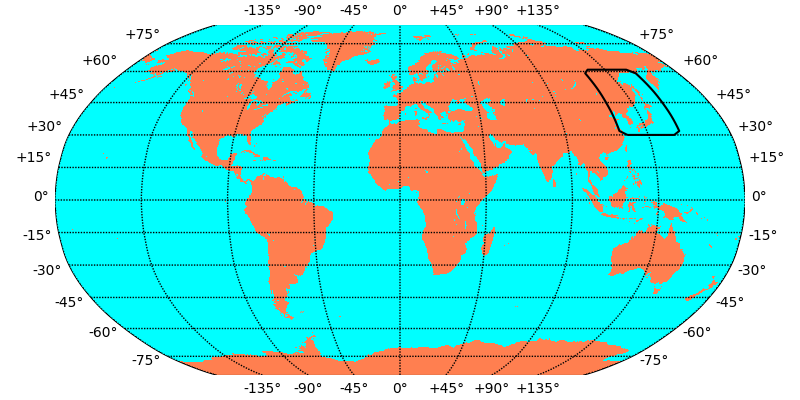

In [390]:
fig=plt.figure(figsize=(8,4),constrained_layout=True)
ax=fig.gca()

In [371]:
m=Map("surface",ax,projection="robin")

In [481]:
fig.clf()
m.ax=fig.gca()
m.drawmapboundary=dict(color='k')
m.drawcountries=None
m.warpimage=dict(alpha=0.7)
m.image="moon-map.jpg"
m.warpimage=dict(alpha=0.7)
m.setDecoration()

<IPython.core.display.Javascript object>


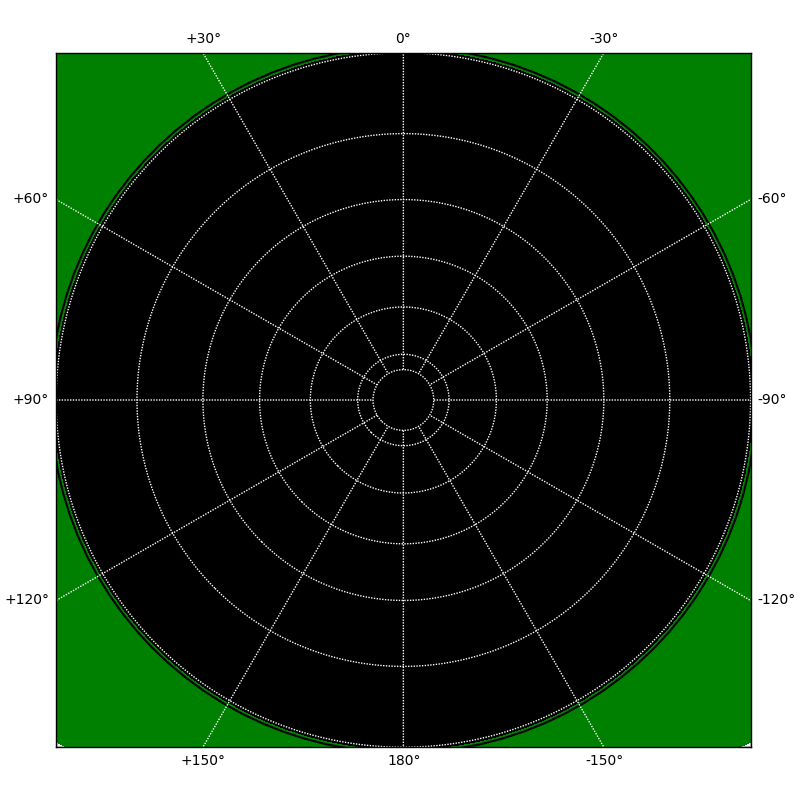

In [514]:
fig=plt.figure(figsize=(8,8),constrained_layout=True)
ax=fig.gca()

In [490]:
from matplotlib import colors

In [493]:
cmap = colors.ListedColormap(['g','k'])

In [515]:
fig.clf()
ax=fig.gca()
m=Map("sky",ax)
m.drawmapboundary.update(dict(fill_color=None))
m.setDecoration()

## Contours

## Interpolation

### Interpolation in the whole sphere

<IPython.core.display.Javascript object>


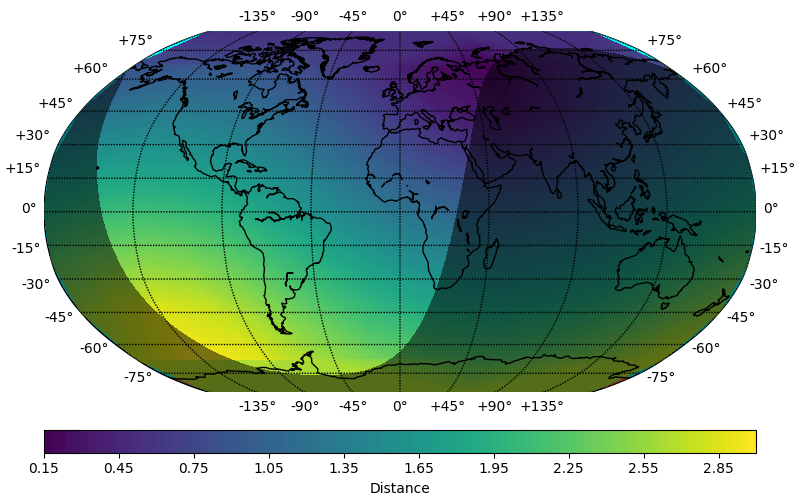

Text(0.5, 0, 'Distance')

In [9]:
fig=plt.figure(figsize=(8,5),constrained_layout=True)
ax=fig.gca()
G=Map("surface")
G.drawMap(ax)
nlon,nlat,lons,lats,val=G.makeGrid(4,4)
for i in range(nlat):
    for j in range(nlon):
        lat=lats[i,j]
        lon=lons[i,j]
        val[i,j]=Util.arcDistance(lon*Angle.Deg,lat*Angle.Deg,50.0*Angle.Deg,60.0*Angle.Deg)
cont=G.area.contourf(lons,lats,val,levels=100,latlon=True)
coasts=G.area.drawcoastlines(**G.drawcoastlines)
cbar=fig.colorbar(cont,drawedges=False,orientation="horizontal")
cbar.ax.set_xlabel("Distance")

### Interpolation in a hemisphere

<IPython.core.display.Javascript object>


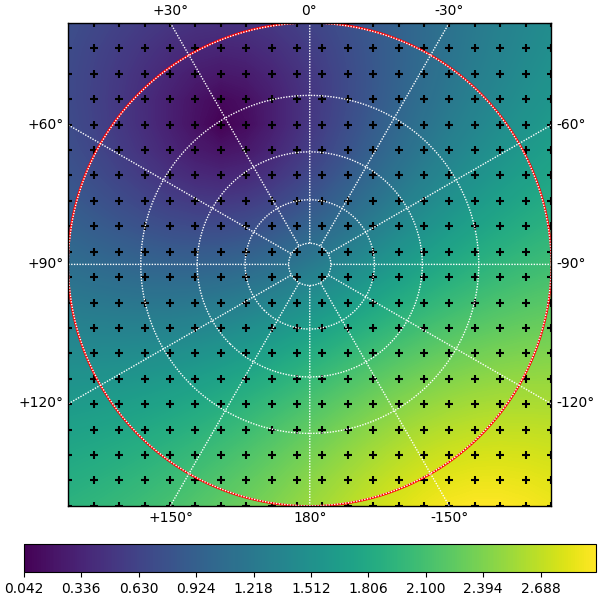

In [10]:
fig=plt.figure(figsize=(6,6),constrained_layout=True)
ax=fig.gca()
ms=Map("sky")
ms.drawMap(ax)
nAs=nhs=20
nAs,nhs,As,hs,val=ms.makeGrid(nAs,nhs)
for i in range(nhs):
    for j in range(nAs):
        h=hs[i,j]
        A=As[i,j]
        val[i,j]=Util.arcDistance(A*Angle.Deg,h*Angle.Deg,30.0*Angle.Deg,20.0*Angle.Deg)
cont=ms.area.contourf(As,hs,val,levels=1000,latlon=True)
ms.scatterMap(As,hs,marker='+',color='k')
cbar=fig.colorbar(cont,drawedges=False,orientation="horizontal")

--End--

## Postprocessing